0. Install and import Dependencies

In [1]:
!pip install torch torchvision torchaudio


In [2]:
!pip install easyocr
!pip install imutils

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

1. Read in Image, Grayscale and Blur

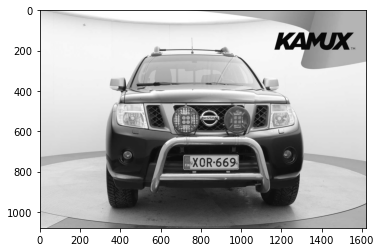

In [4]:
img = cv2.imread('image3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

2. Apply filter and find edges for localization

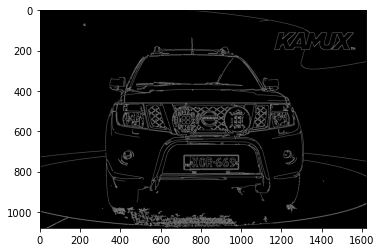

In [5]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

3. Find Contours and apply mask

In [6]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [7]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [8]:
location

array([[[710, 725]],

       [[717, 792]],

       [[986, 784]],

       [[982, 717]]], dtype=int32)

In [9]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

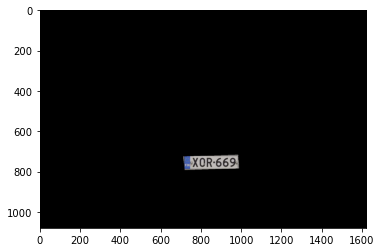

In [10]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [11]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

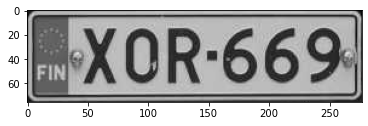

In [12]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

4. Use Easy OCR to Read text

In [13]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[5, 41], [35, 41], [35, 61], [5, 61]], 'FIN', 0.9978594207073687),
 ([[37, 7], [269, 7], [269, 71], [37, 71]], 'XOR669', 0.998391021657552)]

In [14]:
for r in result:
    print(np.sum(np.subtract(r[0][1], r[0][0])))

30
232


In [15]:
region_threshold = 0.6

In [16]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]

    plate = []

    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))

        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [17]:
plate = filter_text(cropped_image, result, region_threshold)

5. Render Result

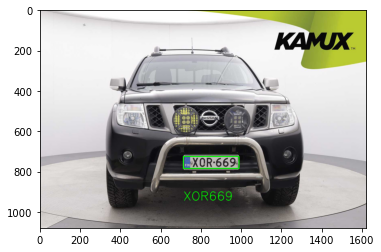

In [18]:
text = plate[0]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+150), fontFace=font, fontScale=2, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))